# Multimodal Search

In [1]:
!pip install widgetsnbextension

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
%pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /private/var/folders/02/75d8xr317_s2rffn9d6w00qw0000gn/T/pip-req-build-64iq68wz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /private/var/folders/02/75d8xr317_s2rffn9d6w00qw0000gn/T/pip-req-build-64iq68wz
  Resolved https://github.com/huggingface/transformers to commit ee8e80a060d65ab349743ffcb5842365eb0e5606
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# All imports


In [3]:
# https://huggingface.co/datasets/detection-datasets/coco
import torch
from datasets import load_from_disk
from datasets import load_dataset

from transformers import AutoFeatureExtractor, CvtForImageClassification
from transformers import ViTModel

from transformers import AutoFeatureExtractor, AutoModel
import torchvision.transforms as T

import os
import shutil
import matplotlib.pyplot as plt

import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import gradio as gr
from PIL import Image
from sys import platform

import matplotlib.image as mpimg
device = "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())
print(device)


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace (__ZN3c106detail19maybe_wrap_dim_slowExxb)
  warn(f"Failed to load image Python extension: {e}")


cpu


In [4]:

# RUN ONCE
print("loading dataset")


if platform == "linux" or platform == "linux2":
    # linux
    dataset = load_dataset("detection-datasets/coco", cache_dir="/data/volume_2/datasets/")
elif platform == "darwin":
    # OS X
    dataset = load_dataset("detection-datasets/coco")
elif platform == "win32":
    # Windows...
    dataset = load_dataset("detection-datasets/coco")


# https://huggingface.co/blog/image-similarity


print("loading model 4")
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
print("loading model to device")
model.to(device)
print("model downloaded")



loading dataset


Found cached dataset parquet (/Users/alves/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--coco-64ef6d5414f6b8df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

loading model 4
loading model to device
model downloaded


In [5]:
# RUN ONCE

num_samples = 100
seed = 42
print("load dataset again")
if platform == "linux" or platform == "linux2":
    # linux
    dataset = load_dataset("detection-datasets/coco", cache_dir="/data/volume_2/datasets/")
elif platform == "darwin":
    # OS X
    dataset = load_dataset("detection-datasets/coco")
elif platform == "win32":
    # Windows...
    dataset = load_dataset("detection-datasets/coco")


dataset = dataset["train"]

# dataset = dataset["train"].shuffle(seed=seed).select(range(num_samples))
print("initialise")
dataset.__len__()

load dataset again


Found cached dataset parquet (/Users/alves/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--coco-64ef6d5414f6b8df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

initialise


117266

In [6]:
# THIS IS FAST

print("imported torchvision.transforms as T")


if platform == "linux" or platform == "linux2":
    # linux
    extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', cache_dir="/data/volume_2/datasets/")
elif platform == "darwin":
    # OS X
    extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
elif platform == "win32":
    # Windows...
    extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')



model_input_size = 224
# Data transformation chain.
print("transforming data")
transformation_chain = T.Compose(
    [
        # use https://huggingface.co/microsoft/cvt-21-384 
        T.Resize(model_input_size),
        T.CenterCrop(model_input_size),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
        
    ]
)
print("transformed data")

imported torchvision.transforms as T
transforming data
transformed data


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:

# RUN ONCE 
# ------------------------------------------------------------
# ONCE THIS IS DONE, YOU CAN RUN THE PIPELINE
print("imported os, shutil")
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device
    print("extracting embeddings")
    def pp(batch):
        images = batch["image"]
        # do not forget to convert to RGB
        # print("extracting embeddings torch stack")
        images = torch.stack([transformation_chain(image.convert('RGB')) for image in images])
        # print("extracting embeddings to device")
        images = images.to(device)

        with torch.no_grad():
            # print("extracting embeddings model")
            embeddings = model(images)
            # 0 because [CLS] token that represent the whole class https://github.com/huggingface/transformers/issues/16984
            embeddings = embeddings.last_hidden_state[:, 0]
            embeddings = embeddings.cpu()

            # print(embeddings.shape)
            return {"embeddings": embeddings}
    print("extracted embeddings pp")
    return pp



# ------------------------------------------------------------
# ONCE THIS IS DONE, YOU CAN RUN THE PIPELINE

imported os, shutil


In [8]:

# ! COMMENTED OUT SINCE WE HAVE ALREADY RUN THIS
# RUN ONCE - THIS SAVES TO DISK - sometimes you can get away without doing this after restarting the kernel
# ------------------------------------------------------------
# ONCE THIS IS DONE, YOU CAN RUN THE PIPELINE

# if memory is an issue, you can use a smaller batch size
# batch_size = 32
# print("extracting embeddings main")
# extract_fn = extract_embeddings(model.to(device))

# save_path = "./data/coco_embeddings"


# # if coco embedding dataset is not on disk, do map
# # if not os.path.exists(save_path):
# print("mapping dataset")
# dataset_emb = dataset.map(extract_fn, batched=True, batch_size=batch_size)
# if os.path.exists(save_path):
#     print("removing old dataset")
#     shutil.rmtree(save_path)

# print("saving dataset")
# dataset_emb.save_to_disk(save_path)
# print("dataset saved")
# ------------------------------------------------------------
# ONCE THIS IS DONE, YOU CAN RUN THE PIPELINE

In [9]:

# THIS IS FAST
# https://huggingface.co/course/chapter5/6?fw=pt#using-faiss-for-efficient-similarity-search
save_path = "./data/coco_embeddings"
dataset_emb = load_from_disk(save_path)
print("dataset loaded")
# print(dataset_emb["embeddings"])
print(dataset_emb.__len__())

dataset_emb.add_faiss_index(column="embeddings")

dataset loaded
117266


  0%|          | 0/118 [00:00<?, ?it/s]

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects', 'embeddings'],
    num_rows: 117266
})

In [10]:
def get_embeddings(image):
    image = transformation_chain(image.convert('RGB'))
    image = torch.stack([image])
    image = image.to(device)
    with torch.no_grad():
        embeddings = model(image)
        embeddings = embeddings.last_hidden_state[:, 0].cpu()
        print(embeddings.shape)
        embeddings = embeddings.squeeze(0)
        return embeddings

torch.Size([1, 768])


torch.Size([768])

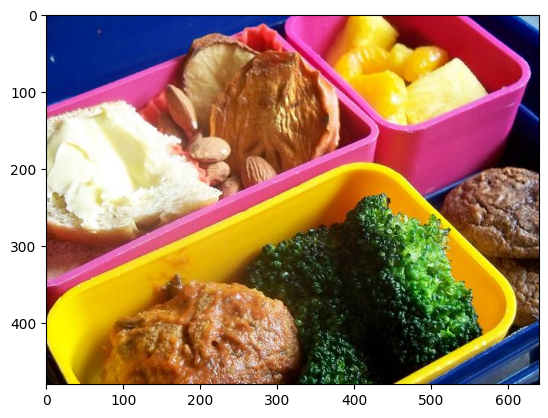

In [11]:
# THIS IS FOR TESTING
image = dataset_emb[0]["image"]

# print image
import matplotlib.pyplot as plt
plt.imshow(image)

question_embedding = get_embeddings(image)
question_embedding.shape

In [12]:
# Define emebdding retrieval functions

def get_nearest_examples(embedding, how_many=5):
    return dataset_emb.get_nearest_examples("embeddings", embedding.numpy(), k=how_many)

def plot_nearest_samples(samples, how_many=5):

    sample_images = samples["image"]

    fig, axs = plt.subplots(1, how_many, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.imshow(sample_images[i])
        ax.axis("off")
    plt.show()


Current Time = 13:46:54
torch.Size([768])
[ 0.5957258 25.292553  25.615013  26.062172  26.09325  ]


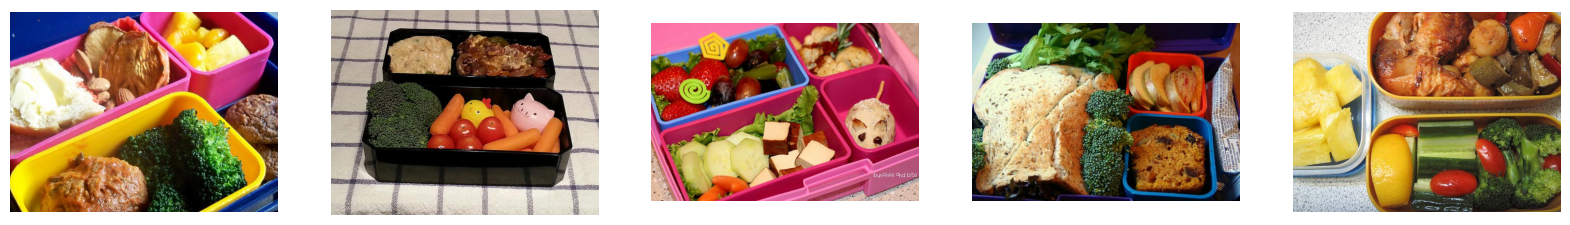

Current Time = 13:47:24


In [13]:
# THIS IS FOR TESTING
# TAKES ABOUT 20-25 SECONDS
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

print(torch.tensor(dataset_emb["embeddings"][32]).shape)

scores, samples = get_nearest_examples(question_embedding)
print(scores)
plot_nearest_samples(samples)

now_finish = datetime.now()

current_time = now_finish.strftime("%H:%M:%S")
print("Current Time =", current_time)

## Pix2Pix

In [16]:
# TAKES ABOUT 20-25 SECONDS

# https://huggingface.co/timbrooks/instruct-pix2pix
model_id = "timbrooks/instruct-pix2pix"
print("Loading model...")
if platform == "linux" or platform == "linux2":
    # linux
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, safety_checker=None, cache_dir="/data/volume_2/datasets/")
elif platform == "darwin":
    # OS X
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float32, safety_checker=None)

elif platform == "win32":
    # Windows...
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float32, safety_checker=None)



print("Model loaded successfully!")
pipe.to(device)
print("Model moved to MPS successfully!")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
print("Scheduler loaded successfully!")





Loading model...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Model loaded successfully!
Model moved to MPS successfully!
Scheduler loaded successfully!


In [17]:
def download_image(url):
    print("Downloading image...")
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    print("Image opened successfully!")
    image = PIL.ImageOps.exif_transpose(image)
    print("transposed successfully!")
    image = image.convert("RGB")
    print(f"Image size: {image.size}")
    print("Image downloaded successfully!")
    image 
    return image

Image opened successfully!
transposed successfully!
Image size: (512, 512)
Image downloaded successfully!


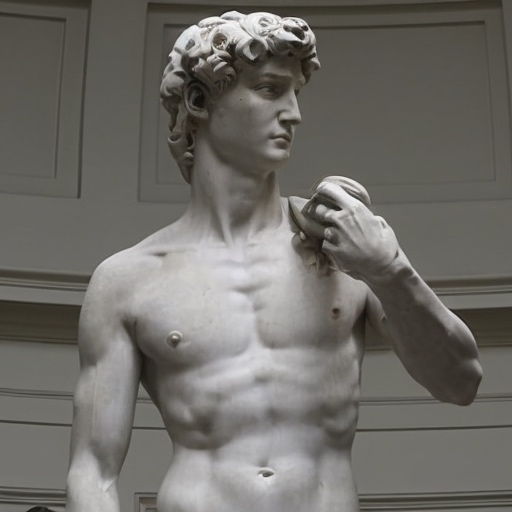

In [18]:
# THIS IS FOR TESTING
# This downloads the image - FAST
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"

image_david = download_image(url)
image_david

In [26]:
# !pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/rocm5.1.1 

# !python3 launch.py --precision full --no-half

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/rocm5.1.1
python3: can't open file '/data/volume_2/IR_Group_44/launch.py': [Errno 2] No such file or directory


  0%|          | 0/10 [00:00<?, ?it/s]

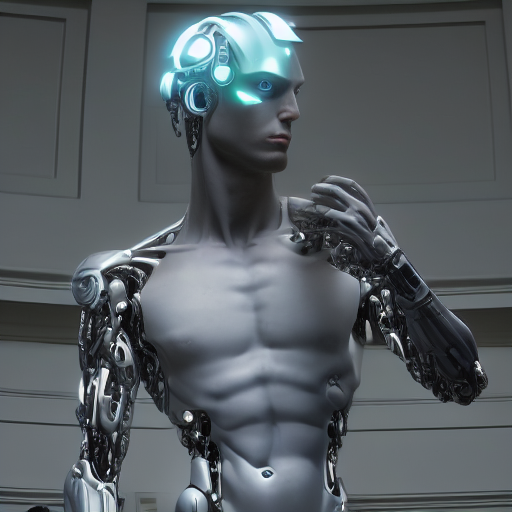

In [19]:
# THIS IS FOR TESTING
# This runs the image through the model
# TAKES ABOUT 20-25 SECONDS
# ! VERY RESOURCE INTENSIVE ! - Actually scales with the image size/dimensions
# ! NOT RECOMMENDED TO RUN ANYTHING ELSE WHILE THIS IS RUNNING !
prompt = "turn him into cyborg"
images_david_diffused = pipe(prompt, image=image_david, num_inference_steps=10, image_guidance_scale=1).images
images_david_diffused[0]

In [ ]:
images_david_diffused[0].save("./diffused_images/test.png")

torch.Size([1, 768])


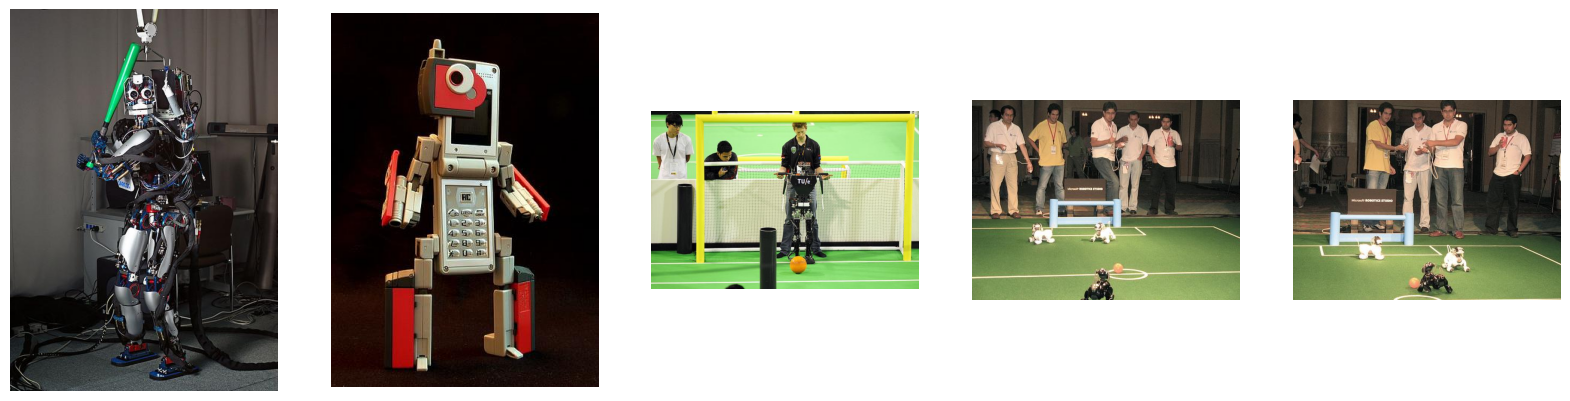

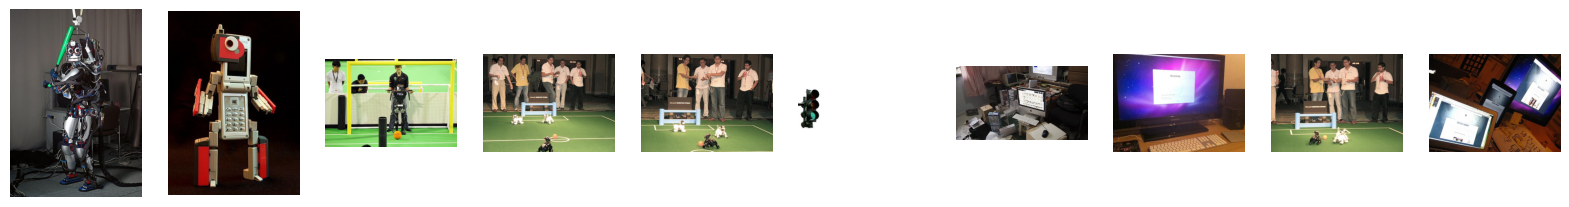

In [20]:
# THIS IS FOR TESTING
# FAST
# This gives us the closest images to the output of the model
pix2pix_embedding = get_embeddings(images_david_diffused[0])

pix2pix_scores, pix2pix_samples  = get_nearest_examples(pix2pix_embedding, how_many=10)

plot_nearest_samples(pix2pix_samples)
plot_nearest_samples(pix2pix_samples, how_many=10)

def plot_nearest_samples(samples, how_many=5):

    sample_images = samples["image"]

    fig, axs = plt.subplots(1, how_many, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.imshow(sample_images[i])
        ax.axis("off")
    plt.show()

## UI

In [18]:
# CAPTIONING IMAGES
# We use this to try and convert the images into a textual output
# That way we can evaluate them as documents
# https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
# from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
# import torch
# from PIL import Image


# if platform == "linux" or platform == "linux2":
#     # linux
# #     pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None, cache_dir="/data/volume_2/datasets/")
#     model_caption = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning", cache_dir="/data/volume_2/datasets/").to(device)
# elif platform == "darwin":
#     # OS X
#     model_caption = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)

# elif platform == "win32":
#     # Windows...
#     model_caption = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)

# model_caption = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
# feature_extractor_caption = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# tokenizer_caption = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# device_for_caption = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_caption.to(device_for_caption)

In [44]:
######################
# IMAGE CAPTIONING
######################
# max_length = 24
# num_beams = 2
# gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
# def predict_caption(images):
#   # mps is not supported yet
#   pixel_values = feature_extractor_caption(images=images, return_tensors="pt").pixel_values.to("cpu")

#   output_ids = model_caption.generate(pixel_values, **gen_kwargs)

#   preds = tokenizer_caption.batch_decode(output_ids, skip_special_tokens=True)
#   preds = [pred.strip() for pred in preds]
#   return preds


# caption_david = predict_caption([image_david])
# caption_david_diffused = predict_caption([images_diffused[0]])
# caption_result_1 = predict_caption(pix2pix_samples["image"][0])

# print(caption_david)
# print(caption_david_diffused)
# print(caption_result_1)


['a man in a white shirt is holding a white object']
['a colorful bird is standing on top of a green plant']
['a baseball player holding a bat in a room']


In [21]:
######################
# IMAGE CAPTIONING 2
######################
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

if platform == "linux" or platform == "linux2":
    # linux
#     pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None, cache_dir="/data/volume_2/datasets/")
    processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", cache_dir="/data/volume_2/datasets/")
    model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", cache_dir="/data/volume_2/datasets/")
elif platform == "darwin":
    # OS X
    processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
    model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
elif platform == "win32":
    # Windows...
    processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
    model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")



# img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

raw_image = images_david_diffused[0]

# conditional image captioning
text = "a photography of"
inputs = processor_blip(raw_image, text, return_tensors="pt")

out = model_blip.generate(**inputs)
print(processor_blip.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor_blip(raw_image, return_tensors="pt")

out = model_blip.generate(**inputs)
print(processor_blip.decode(out[0], skip_special_tokens=True))

/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a robot with a glowing head and arm
there is a robot with a glowing head and a hand


In [22]:
def predict_caption_blip(raw_image):
    # conditional image captioning
    text = "a picture of"
    inputs = processor_blip(raw_image, text, return_tensors="pt")

    out = model_blip.generate(**inputs)

    prediction = processor_blip.decode(out[0], skip_special_tokens=True)
    return prediction.split("a picture of ")[1]


In [23]:
caption_david = predict_caption_blip([image_david])
caption_david_diffused = predict_caption_blip([images_david_diffused[0]])
caption_result_1 = predict_caption_blip(pix2pix_samples["image"][0])

print(caption_david)
print(caption_david_diffused)
print(caption_result_1)


a statue of a man holding a apple
a robot with a glowing head and arm
a robot with a green bat in his hand


In [24]:
######################
# SENTENCE SIMILARITY
######################

# This is used to compare the captions of the images -> this is our score for document similarity
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
from sentence_transformers import SentenceTransformer, util
# sentences = ["This is an example sentence", "example of another sentence"]

model_sentences = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# embeddings_1 = model_sentences.encode(sentences[0])
# embeddings_2 = model_sentences.encode(sentences[1])
# cosine_score = util.cos_sim(embeddings_1, embeddings_2)

david_caption_embedding = model_sentences.encode(caption_david)
david_diffused_caption_embedding = model_sentences.encode(caption_david_diffused)
result_1_caption_embedding = model_sentences.encode(caption_result_1)

cosine_score = util.cos_sim(david_caption_embedding, david_diffused_caption_embedding)
cosine_score_2 = util.cos_sim(david_caption_embedding, result_1_caption_embedding)
cosine_score_3 = util.cos_sim(david_diffused_caption_embedding, result_1_caption_embedding)

print(cosine_score)
print(cosine_score_2)
print(cosine_score_3)

# print(str(cosine_score.item()))

tensor([[0.2614]])
tensor([[0.2211]])
tensor([[0.4895]])


In [25]:
# define a function to compare the captions of the images -> this is our score for document similarity
def compare_captions(caption_1, caption_2):
    caption_1_embedding = model_sentences.encode(caption_1)
    caption_2_embedding = model_sentences.encode(caption_2)
    cosine_score = util.cos_sim(caption_1_embedding, caption_2_embedding)
    return cosine_score.item()

In [51]:
####################
# MODIFIED PIPELINE
####################


####################
# RESIZE IMAGES
####################
# Get all the query images from the folder
# Resize the images to 256x256
# Save the resized images to a folder
original_images_folder = "./query_images"
resized_images_folder = "./resized_images"
size = 256, 256
for image_name in [ x for x in sorted(os.listdir(original_images_folder)) if ".DS_Store" not in x ]:
    print("Resizing: " + image_name)
    img = Image.open(os.path.join(original_images_folder,image_name))
    # img = img.resize((256,256))
    img.thumbnail(size, Image.LANCZOS)
    img.save(os.path.join(resized_images_folder,image_name))

# Get image caption
    image_caption = predict_caption_blip([img])
    print(image_caption)







Resizing: 01_red_ferrari.jpg


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a red sports car is shown in a dark room
Resizing: 02_yellow_lamborghini.jpg
a yellow lamb suv driving down a road
Resizing: 03_fluffy_fox_dog.jpeg
a small brown dog sitting on a road
Resizing: 04_pug_smiling_on_grass.jpg
a pug dog laying in the grass with its tongue out


In [52]:
###########################
# CAPTION RESIZED IMAGES
###########################
# Get captions for all resized images
resized_images_folder = "./resized_images"
original_images_captions_file = "./captions/original_images_captions.txt"
resized_images_captions = []
for image_name in [ x for x in sorted(os.listdir(resized_images_folder)) if ".DS_Store" not in x ]:

    print("Captioning: " + image_name)
    img = Image.open(os.path.join(resized_images_folder,image_name))
    image_caption = predict_caption_blip(img)
    print(image_caption)
    resized_images_captions.append(image_caption)

    # Save the captions to a file
    with open(original_images_captions_file, 'w') as f:
        for item in resized_images_captions:
            f.write(item)
            f.write("\n")


Captioning: 01_red_ferrari.jpg


/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a red sports car is shown in a dark room
Captioning: 02_yellow_lamborghini.jpg
a yellow lamb suv driving down a road
Captioning: 03_fluffy_fox_dog.jpeg
a small brown dog sitting on the ground
Captioning: 04_pug_smiling_on_grass.jpg
a pug dog laying in the grass with its tongue out


In [53]:
module_path = os.path.abspath(os.path.join('./prompts'))
from prompts.query_prompts import query_prompts_for_diffusion
%load_ext autoreload
%autoreload 2

# import prompts.query_prompts

# reload(prompts.query_prompts)

# prompts.reload(query_prompts)
# query_prompts_for_diffusion

prompts = query_prompts_for_diffusion
print(prompts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['turn the ferrari from red to blue', 'turn the lamborghini from orange to green', 'make the foxy dog less fluffy', 'make the pug more fluffy']


In [54]:

####################
# DIFFUSE IMAGES
####################
# Get all the query prompts from the file
# Run the resized query images through the model using the query prompts
# Save the output images to a folder (diffused_images)
import sys
resized_images_folder = "./resized_images"
diffused_images_folder = "./diffused_images"

if module_path not in sys.path:
    sys.path.append(module_path)

print("QUERY PROMPTS: " + str(query_prompts_for_diffusion))

for index, image_name in enumerate([ x for x in sorted(os.listdir(resized_images_folder)) if ".DS_Store" not in x ]):
    print("Diffusing: " + image_name + " with prompt: " + prompts[index])
    image = Image.open(os.path.join(resized_images_folder,image_name))
    # for prompt in query_prompts_for_diffusion:
    prompt = prompts[index]
    print("Prompt: " + prompt)
    images_diffused = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
    images_diffused[0].save(os.path.join(diffused_images_folder, image_name.split(".")[0] + "_" + prompt.replace(" ", "_") + ".jpeg"))



QUERY PROMPTS: ['turn the ferrari from red to blue', 'turn the lamborghini from orange to green', 'make the foxy dog less fluffy', 'make the pug more fluffy']
Diffusing: 01_red_ferrari.jpg with prompt: turn the ferrari from red to blue
Prompt: turn the ferrari from red to blue


  0%|          | 0/10 [00:00<?, ?it/s]

Diffusing: 02_yellow_lamborghini.jpg with prompt: turn the lamborghini from orange to green
Prompt: turn the lamborghini from orange to green


  0%|          | 0/10 [00:00<?, ?it/s]

Diffusing: 03_fluffy_fox_dog.jpeg with prompt: make the foxy dog less fluffy
Prompt: make the foxy dog less fluffy


  0%|          | 0/10 [00:00<?, ?it/s]

Diffusing: 04_pug_smiling_on_grass.jpg with prompt: make the pug more fluffy
Prompt: make the pug more fluffy


  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
###########################
# CAPTION DIFFUSED IMAGES
###########################
# Get captions for all diffused images
diffused_images_folder = "./diffused_images"
diffused_images_captions_file = "./captions/diffused_images_captions.txt"
diffused_images_captions = []
for image_name in [ x for x in sorted(os.listdir(diffused_images_folder)) if ".DS_Store" not in x ]:
    print("Captioning: " + image_name)
    img = Image.open(os.path.join(diffused_images_folder,image_name))
    image_caption = predict_caption_blip(img)
    print(image_caption)
    diffused_images_captions.append(image_caption)

    # Save the captions to a file
    with open(diffused_images_captions_file, 'w') as f:
        for item in diffused_images_captions:
            f.write(item)
            f.write("\n")

Finding similar images for: 01_red_ferrari_turn_the_ferrari_from_red_to_blue.jpeg
torch.Size([1, 768])


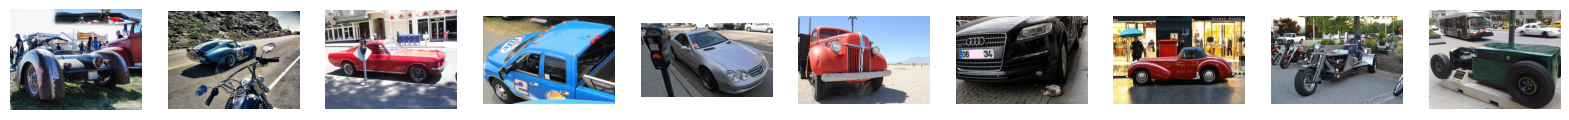

a car with a large tire parked in a field
a blue sports car driving down a road next to a motorcycle
a red car parked next to a parking meter
a blue truck with a number 2 on the bed
a silver mercedes parked next to a parking meter
an old red truck parked in a desert
a cat laying on the ground next to a parked car
a red car parked on the side of a street
a group of motorcycles parked next to each other
a green hot rod car is parked on the side of the street
Finding similar images for: 02_yellow_lamborghini_turn_the_lamborghini_from_orange_to_blue.jpeg
torch.Size([1, 768])


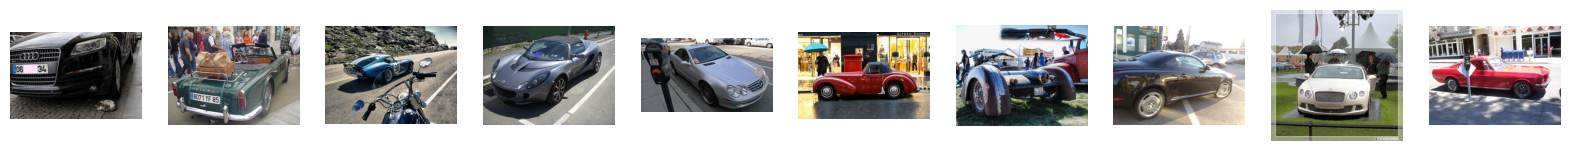

a cat laying on the ground next to a parked car
a green convertible car with luggage on top
a blue sports car driving down a road next to a motorcycle
a silver sports car parked in a parking lot
a silver mercedes parked next to a parking meter
a red car parked on the side of a street
a car with a large tire parked in a field
a black sports car parked in a parking lot
a car is parked in the rain with people holding umbrellas
a red car parked next to a parking meter
Finding similar images for: 02_yellow_lamborghini_turn_the_lamborghini_from_orange_to_green.jpeg
torch.Size([1, 768])


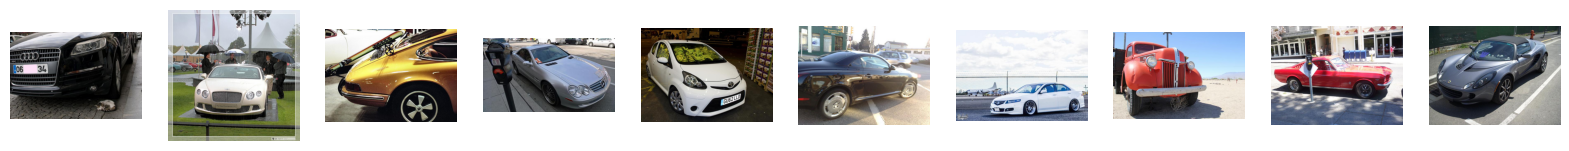

a cat laying on the ground next to a parked car
a car is parked in the rain with people holding umbrellas
a car with a ski rack on the back of it
a silver mercedes parked next to a parking meter
a small white car with a bunch of bananas in the back
a black sports car parked in a parking lot
a white car parked in front of a fence
an old red truck parked in a desert
a red car parked next to a parking meter
a silver sports car parked in a parking lot
Finding similar images for: 03_fluffy_fox_dog_make_the_foxy_dog_less_fluffy.jpeg
torch.Size([1, 768])


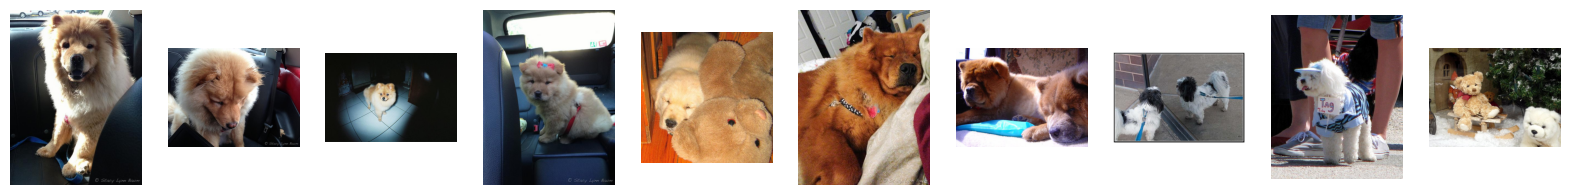

a dog sitting in the back seat of a car
a dog sitting in a car with a laptop
a dog standing on a tiled floor in a dark room
a small dog sitting on the back seat of a car
a dog sleeping next to a stuffed animal
a dog is sleeping on a bed with a blanket
two dogs laying on a couch in a car
two small dogs are looking at themselves in a mirror
a small white dog wearing a shirt and hat
a teddy bear sitting on a sled next to a tree
Finding similar images for: 04_pug_smiling_on_grass_make_the_pug_more_fluffy.jpeg
torch.Size([1, 768])


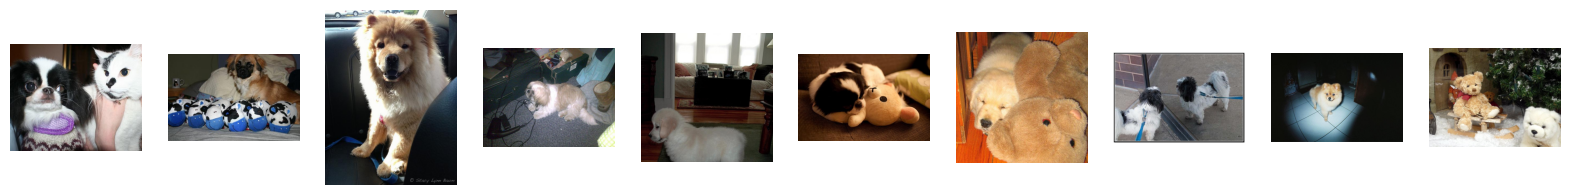

a cat and a dog are sitting on a couch
a dog sitting on a bed with a bunch of stuffed animals
a dog sitting in the back seat of a car
a dog laying on the floor next to a suitcase
a white dog standing on a rug in a living room
a small dog laying on a pillow next to a stuffed animal
a dog sleeping next to a stuffed animal
two small dogs are looking at themselves in a mirror
a dog standing on a tiled floor in a dark room
a teddy bear sitting on a sled next to a tree


In [49]:

###########################
# GET NEAREST IMAGES TO DIFFUSED IMAGES
# GET CAPTIONS FOR NEAREST IMAGES
###########################
# Find the most similar images to the output images
# Get the embeddings for the output images
diffused_images_folder = "./diffused_images"
nearest_results_diffused_captions_file = "./captions/nearest_results_diffused_captions.txt"
how_many_results = 10

# Save the captions to a file
with open(nearest_results_diffused_captions_file, 'w') as f:
    for image_name in [ x for x in sorted(os.listdir(diffused_images_folder)) if ".DS_Store" not in x ]:
        print("Finding similar images for: " + image_name)
        image = Image.open(os.path.join(diffused_images_folder,image_name))
        pix2pix_embedding = get_embeddings(image)
        pix2pix_scores, pix2pix_sample = get_nearest_examples(pix2pix_embedding, how_many=how_many_results)
        plot_nearest_samples(pix2pix_sample, how_many=how_many_results)

    
        # Get the captions for the output images
        for result in pix2pix_sample['image']:
            # print(result)
            image_caption = predict_caption_blip(result)
            print(image_caption)

            # Save the captions to a file
            f.write(image_caption)
            f.write("\n")

Finding similar images for: 01_red_ferrari.jpg
torch.Size([1, 768])


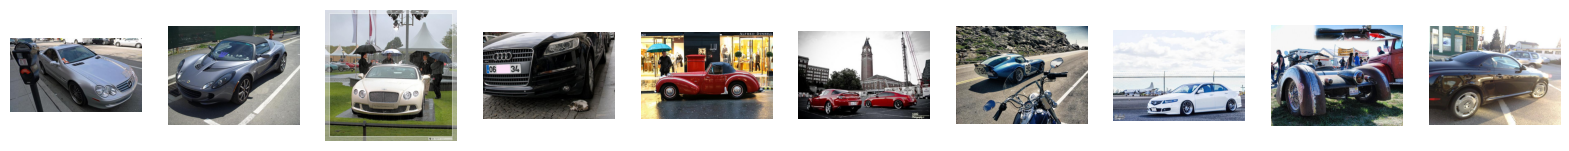

/Users/alves/anaconda3/envs/multimodal-search/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a silver mercedes parked next to a parking meter
a silver sports car parked in a parking lot
a car is parked in the rain with people holding umbrellas
a cat laying on the ground next to a parked car
a red car parked on the side of a street
two red cars parked in a parking lot
a blue sports car driving down a road next to a motorcycle
a white car parked in front of a fence
a car with a large tire parked in a field
a black sports car parked in a parking lot
Finding similar images for: 02_yellow_lamborghini.jpg
torch.Size([1, 768])


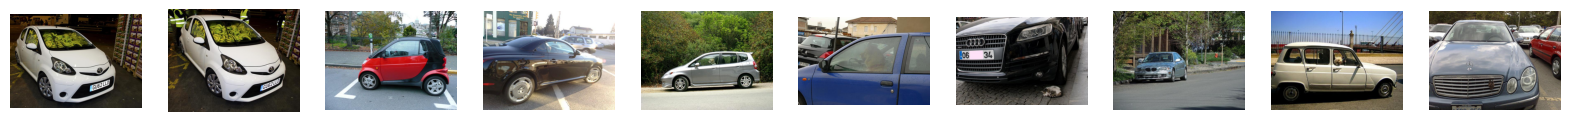

a small white car with a bunch of bananas in the back
a car with a bunch of bananas in the back
a small red car parked in a parking space
a black sports car parked in a parking lot
a small silver car parked on the side of the road
a dog sitting in the passenger seat of a blue car
a cat laying on the ground next to a parked car
a car parked on the side of a road
a small white car with a dog in the window
a blue mercedes parked in a parking lot
Finding similar images for: 03_fluffy_fox_dog.jpeg
torch.Size([1, 768])


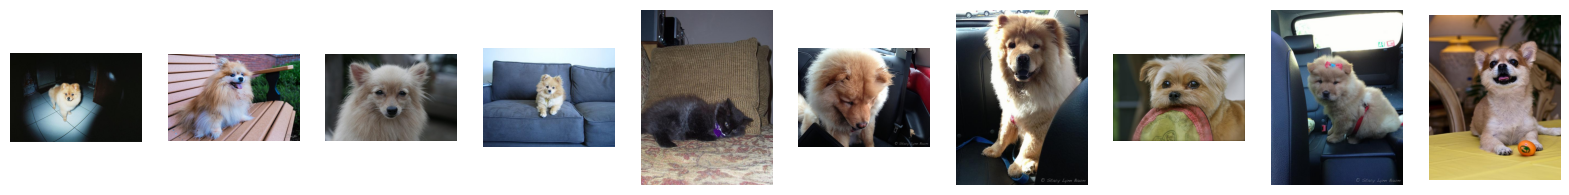

a dog standing on a tiled floor in a dark room
a small dog sitting on a wooden bench
a small dog with a long hair standing in front of a car
a small dog sitting on a couch in a room
a black cat laying on a couch with a purple collar
a dog sitting in a car with a laptop
a dog sitting in the back seat of a car
a dog holding a frisbee in its mouth
a small dog sitting on the back seat of a car
a small dog sitting on a table with a toy
Finding similar images for: 04_pug_smiling_on_grass.jpg
torch.Size([1, 768])


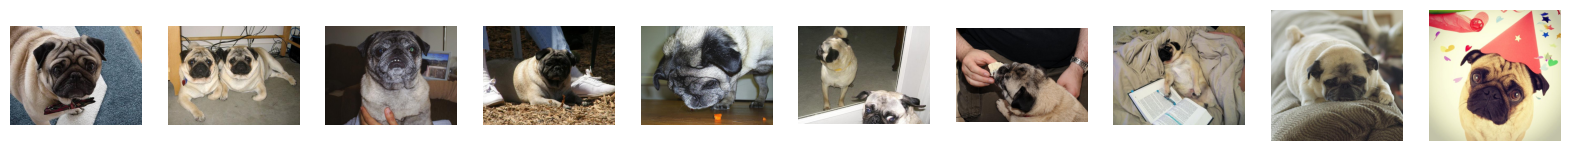

a small dog standing on a rug on a wooden floor
two pug dogs laying under a desk under a desk
a person holding a small dog on a couch
a pug dog laying on the ground next to a person
a pug dog eating carrots on the floor
a dog looking at itself in a mirror
a man is feeding a small dog a piece of food
a pug dog laying on a bed with a book
a pug dog laying on a couch with its head on the arm
a pug dog wearing a party hat with confetti


In [30]:
###########################
# GET NEAREST IMAGES TO ORIGINAL IMAGES
# GET CAPTIONS FOR NEAREST IMAGES
###########################

# Find the most similar images to the original images
# Get the embeddings for the original images
original_images_folder = "./resized_images"
nearest_results_original_captions_file = "./captions/nearest_results_original_captions.txt"
how_many_results = 10

# Save the captions to a file
with open(nearest_results_original_captions_file, 'w') as f:
    for image_name in [ x for x in sorted(os.listdir(original_images_folder)) if ".DS_Store" not in x ]:
        print("Finding similar images for: " + image_name)
        image = Image.open(os.path.join(original_images_folder,image_name))
        pix2pix_embedding = get_embeddings(image)
        pix2pix_scores, pix2pix_sample = get_nearest_examples(pix2pix_embedding, how_many=how_many_results)
        plot_nearest_samples(pix2pix_sample, how_many=how_many_results)


        # Get the captions for the output images
        for result in pix2pix_sample['image']:
            # print(result)
            image_caption = predict_caption_blip(result)
            print(image_caption)

            # Save the captions to a file
            f.write(image_caption)
            f.write("\n")

In [31]:
###########################
# COMPARE CAPTIONS
###########################

# Compare the captions for the original images and the nearest matches images
# Save the results to a file

# Get the captions for the original images
original_images_captions_file = "./captions/original_images_captions.txt"
original_images_captions = []
with open(original_images_captions_file, 'r') as f:
    for line in f:
        original_images_captions.append(line.strip())

# Get the captions for the nearest matches images
nearest_results_original_captions_file = "./captions/nearest_results_original_captions.txt"
nearest_results_original_captions = []
with open(nearest_results_original_captions_file, 'r') as f:
    for line in f:
        nearest_results_original_captions.append(line.strip())

# Get the captions for the diffused images
diffused_images_captions_file = "./captions/diffused_images_captions.txt"
diffused_images_captions = []
with open(diffused_images_captions_file, 'r') as f:
    for line in f:
        diffused_images_captions.append(line.strip())

# Get the captions for the nearest matches images for the diffused images
nearest_results_diffused_captions_file = "./captions/nearest_results_diffused_captions.txt"
nearest_results_diffused_captions = []
with open(nearest_results_diffused_captions_file, 'r') as f:
    for line in f:
        nearest_results_diffused_captions.append(line.strip())

# Now we have several things to compare using SENTENCE SIMILARITY:
# 1. The captions of the original images + the query text and the captions of the nearest matches images (every original image has 10 nearest matches)
# 2. The captions of the diffused images and the captions of the nearest matches images (every diffused image has 10 nearest matches)
# 3. The captions of the original images + the query text and the captions of the diffused images
# 4. The captions of the original images + the query text and the captions of the nearest matches images for the diffused images (every original image has 10 nearest matches)
# 5. The captions of the diffused images and the captions of the nearest matches images for the original images (every original image has 10 nearest matches)
# We want to save the results to a csv file







In [34]:
# 1. The captions of the original images + the query text and the captions of the nearest matches images (every original image has 10 nearest matches)
# 1.1. The captions of the original images + the query text
original_images_captions_with_query = []
for index, original_image_caption in enumerate(original_images_captions):
    original_images_captions_with_query.append(original_image_caption + " " + query_prompts_for_diffusion[index])

# Compare the captions of the original images + the query text and the captions of the nearest matches images
# Save the results to a file
original_images_captions_with_query_nearest_results_original_captions_file = "./results/original_images_captions_with_query_nearest_results_original_captions.csv"
with open(original_images_captions_with_query_nearest_results_original_captions_file, 'w') as f:
    for index, original_image_caption_with_query in enumerate(original_images_captions_with_query):
        max_similarity_score_for_image = 0
        for nearest_result_original_caption in nearest_results_original_captions[index*10:(index+1)*10]:
            similarity_score = compare_captions(original_image_caption_with_query, nearest_result_original_caption)
            max_similarity_score_for_image = max(max_similarity_score_for_image, similarity_score)
            f.write(original_image_caption_with_query)
            f.write(",")
            f.write(nearest_result_original_caption)
            f.write(",")
            f.write(str(similarity_score))
            f.write("\n")
        print("Max similarity score for image " + str(index) + ": " + str(max_similarity_score_for_image))

Max similarity score for image 0: 0.5283734798431396
Max similarity score for image 1: 0.3756259083747864
Max similarity score for image 2: 0.5211079716682434
Max similarity score for image 3: 0.6829708218574524


In [35]:
# 2. The captions of the diffused images and the captions of the nearest matches images (every diffused image has 10 nearest matches)
# Compare the captions of the diffused images and the captions of the nearest matches images
# Save the results to a file
diffused_images_captions_nearest_results_diffused_captions_file = "./results/diffused_images_captions_nearest_results_diffused_captions.csv"
with open(diffused_images_captions_nearest_results_diffused_captions_file, 'w') as f:
    for index, diffused_image_caption in enumerate(diffused_images_captions):
        max_similarity_score_for_image = 0
        for nearest_result_diffused_caption in nearest_results_diffused_captions[index*10:(index+1)*10]:
            similarity_score = compare_captions(diffused_image_caption, nearest_result_diffused_caption)
            max_similarity_score_for_image = max(max_similarity_score_for_image, similarity_score)
            f.write(diffused_image_caption)
            f.write(",")
            f.write(nearest_result_diffused_caption)
            f.write(",")
            f.write(str(similarity_score))
            f.write("\n")
        print("Max similarity score for image " + str(index) + ": " + str(max_similarity_score_for_image))


Max similarity score for image 0: 0.48947954177856445
Max similarity score for image 1: 0.8514707684516907
Max similarity score for image 2: 0.3072589635848999
Max similarity score for image 3: 0.58967125415802
Max similarity score for image 4: 0.4349084198474884


In [36]:
# 3. The captions of the original images + the query text and the captions of the diffused images
# Compare the captions of the original images + the query text and the captions of the diffused images
# Save the results to a file
original_images_captions_with_query_diffused_images_captions_file = "./results/original_images_captions_with_query_diffused_images_captions.csv"
with open(original_images_captions_with_query_diffused_images_captions_file, 'w') as f:
    for index, original_image_caption_with_query in enumerate(original_images_captions_with_query):
        similarity_score = compare_captions(original_image_caption_with_query, diffused_images_captions[index])
        f.write(original_image_caption_with_query)
        f.write(",")
        f.write(diffused_images_captions[index])
        f.write(",")
        f.write(str(similarity_score))
        f.write("\n")
        print("Similarity score for image " + str(index) + ": " + str(similarity_score))
    

Similarity score for image 0: 0.6445398926734924
Similarity score for image 1: 0.48948514461517334
Similarity score for image 2: 0.10379456728696823
Similarity score for image 3: 0.36327841877937317


In [37]:
# 4. The captions of the original images + the query text and the captions of the nearest matches images for the diffused images (every original image has 10 nearest matches)
# Compare the captions of the original images + the query text and the captions of the nearest matches images for the diffused images
# Save the results to a file
original_images_captions_with_query_nearest_results_diffused_captions_file = "./results/original_images_captions_with_query_nearest_results_diffused_captions.csv"
with open(original_images_captions_with_query_nearest_results_diffused_captions_file, 'w') as f:
    for index, original_image_caption_with_query in enumerate(original_images_captions_with_query):
        max_similarity_score_for_image = 0
        for nearest_result_diffused_caption in nearest_results_diffused_captions[index*10:(index+1)*10]:
            similarity_score = compare_captions(original_image_caption_with_query, nearest_result_diffused_caption)
            max_similarity_score_for_image = max(max_similarity_score_for_image, similarity_score)
            f.write(original_image_caption_with_query)
            f.write(",")
            f.write(nearest_result_diffused_caption)
            f.write(",")
            f.write(str(similarity_score))
            f.write("\n")
        print("Max similarity score for image " + str(index) + ": " + str(max_similarity_score_for_image))

Max similarity score for image 0: 0.5283734798431396
Max similarity score for image 1: 0.41488632559776306
Max similarity score for image 2: 0.31167104840278625
Max similarity score for image 3: 0.39288848638534546


In [38]:
# 5. The captions of the diffused images and the captions of the nearest matches images for the original images (every original image has 10 nearest matches)
# Compare the captions of the diffused images and the captions of the nearest matches images for the original images
# Save the results to a file
diffused_images_captions_nearest_results_original_captions_file = "./results/diffused_images_captions_nearest_results_original_captions.csv"
with open(diffused_images_captions_nearest_results_original_captions_file, 'w') as f:
    for index, diffused_image_caption in enumerate(diffused_images_captions):
        max_similarity_score_for_image = 0
        for nearest_result_original_caption in nearest_results_original_captions[index*10:(index+1)*10]:
            similarity_score = compare_captions(diffused_image_caption, nearest_result_original_caption)
            max_similarity_score_for_image = max(max_similarity_score_for_image, similarity_score)
            f.write(diffused_image_caption)
            f.write(",")
            f.write(nearest_result_original_caption)
            f.write(",")
            f.write(str(similarity_score))
            f.write("\n")
        print("Max similarity score for image " + str(index) + ": " + str(max_similarity_score_for_image))

Max similarity score for image 0: 0.7066401243209839
Max similarity score for image 1: 0.5189275741577148
Max similarity score for image 2: 0.24662940204143524
Max similarity score for image 3: 0.4255884885787964
Max similarity score for image 4: 0
